### Modelo de regresion logistica para la predicción de victorias, empates, y derrotas.
- Preprocesamiento: Convertimos result en binario (1 si gana, 0 si no gana).
- Selección de Características: Usamos variables relevantes (home_adv, estadísticas del equipo y del rival).
- Entrenamiento del Modelo: Usamos LogisticRegression de sklearn.
- Evaluación: Métricas como accuracy y classification_report.

#### 1. Carga de datos y preparación
- Cargamos el dataset y seleccionamos las características relevantes.
- Eliminamos las columnas `goals_team`, `goals_rival` y `result` (ya que `result` será la variable objetivo).
- Separamos los datos en entrenamiento y validación (los últimos 15 partidos serán usados para evaluar el modelo).


In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import mlflow
import dagshub
import warnings
warnings.filterwarnings("ignore")


Conexión con MLFLow

In [34]:
USERNAME = "anaigs"
TOKEN = "6906b8ec6ea34a63bacb40b89eed8c6e9b9ff49d"
REPO_NAME = "tfg_inso_github"

# Configurar el tracking URI con autenticación
mlflow.set_tracking_uri(f"https://dagshub.com/anaigs/tfg_inso_github.mlflow")
dagshub.init(repo_owner=USERNAME, repo_name="tfg_inso_github", mlflow=True)

print(mlflow.get_tracking_uri()) 

Initialized MLflow to track repo "anaigs/tfg_inso_github"

Repository anaigs/tfg_inso_github initialized!

https://dagshub.com/anaigs/tfg_inso_github.mlflow


In [3]:
# Cargar los datos
file_path = "../../datasets/datasets_equipos/real_madrid.csv"
df = pd.read_csv(file_path)
df

,season,date,team,rival_team,home_adv,last_season_team,last_season_rival,pct_wins,avg_goals_scored,avg_goals_received,...,avg_goals_received_vs_rival,goal_difference_vs_rival,goals_team,goals_rival,result,AvgWin,AvgLoss,AvgDraw,AvgAHWin,AvgAHLoss
0,2003-04,2003-08-30,Real Madrid,Betis,1,21,21,0.00,0.00,0.00,...,0.0,0.0,2,1,1,1.38,7.18,4.00,1.94,1.91
1,2003-04,2003-09-02,Real Madrid,Villarreal,0,21,21,1.00,2.00,1.00,...,0.0,0.0,1,1,0,1.80,3.99,3.28,1.96,1.88
2,2003-04,2003-09-13,Real Madrid,Valladolid,1,21,21,0.50,1.50,1.00,...,0.0,0.0,7,2,1,1.29,9.10,4.39,1.82,2.02
3,2003-04,2003-09-21,Real Madrid,Malaga,0,21,21,0.67,3.33,1.33,...,0.0,0.0,3,1,1,1.62,4.90,3.40,1.92,1.93
4,2003-04,2003-09-27,Real Madrid,Valencia,0,21,21,0.75,3.25,1.25,...,0.0,0.0,0,2,-1,2.27,2.79,3.13,1.95,1.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
793,2023-24,2024-05-04,Real Madrid,Cadiz,1,2,16,0.80,2.30,0.70,...,2.0,6.0,3,0,1,7.09,6.00,2.13,2.02,1.88
794,2023-24,2024-05-11,Real Madrid,Granada,0,2,21,0.80,2.20,0.70,...,2.0,11.0,4,0,1,3.96,2.52,5.59,1.86,1.99
795,2023-24,2024-05-14,Real Madrid,Alaves,1,2,21,0.90,2.50,0.60,...,4.0,9.0,5,0,1,11.32,8.03,2.46,2.08,1.84
796,2023-24,2024-05-19,Real Madrid,Villarreal,0,2,5,0.90,2.90,0.60,...,6.0,1.0,4,4,0,3.61,2.34,3.35,1.84,2.02


Inicializamos repositorio de dagshub

In [4]:
# Eliminar columnas irrelevantes
df = df.drop(columns=["season", "date", "team"])

# Codificar la columna 'rival_team'
label_encoder = LabelEncoder()
df["rival_team"] = label_encoder.fit_transform(df["rival_team"])

#### Preparación de datos para el modelo
- Eliminamos las columnas `goals_team`, `goals_rival` y `result` (esta última será nuestra variable objetivo).
- Convertimos `rival_team` en valores numéricos usando **Label Encoding**.
- Separamos los datos en **X (variables predictoras)** e **y (variable objetivo)**.
- Dividimos los datos en entrenamiento y validación:
  - **Entrenamiento:** Todos los partidos excepto los últimos 15.
  - **Validación:** Últimos 15 partidos.
- Escalamos los datos usando `StandardScaler` para mejorar la estabilidad del modelo.

In [5]:
# Codificar la columna 'rival_team'
label_encoder = LabelEncoder()
df["rival_team"] = label_encoder.fit_transform(df["rival_team"])

# Separar variables predictoras y variable objetivo
X = df.drop(columns=["goals_team", "goals_rival", "result"])
y = df["result"]  # -1 (derrota), 0 (empate), 1 (victoria)

# Dividir en conjunto de entrenamiento y validación
X_train, X_val = X.iloc[:-15], X.iloc[-15:]
y_train, y_val = y.iloc[:-15], y.iloc[-15:]

# Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


Reporte de clasificación:
               precision    recall  f1-score   support

Derrota (-1)       0.00      0.00      0.00         0
  Empate (0)       1.00      0.25      0.40         4
Victoria (1)       0.79      1.00      0.88        11

    accuracy                           0.80        15
   macro avg       0.60      0.42      0.43        15
weighted avg       0.84      0.80      0.75        15

Accuracy: 0.8000, Precision: 0.8429, Recall: 0.8000, F1-score: 0.7520


2025/03/08 13:46:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Clases presentes en y_val: {0, 1}


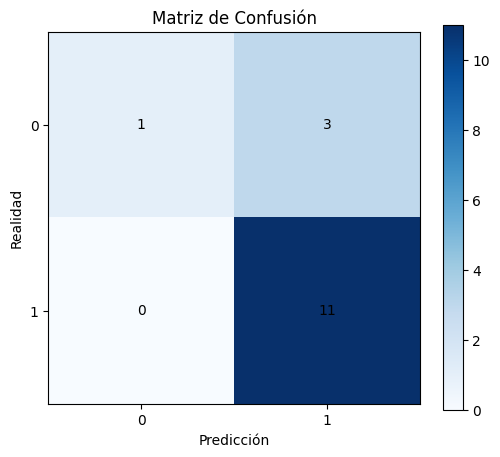

🏃 View run real_madrid_logreg_basic at: https://dagshub.com/anaigs/tfg_inso_github.mlflow/#/experiments/0/runs/456ee9088fac4c25913fa9b5e430f6d5
🧪 View experiment at: https://dagshub.com/anaigs/tfg_inso_github.mlflow/#/experiments/0


In [6]:
with mlflow.start_run(run_name="real_madrid_logreg_basic"):
    # Registrar parámetros en MLflow
    mlflow.log_param("model_type", "Logistic Regression")
    mlflow.log_param("approach", "basic")
    mlflow.log_param("team", "real madrid")
    mlflow.log_param("max_iter", 1000)
    mlflow.log_param("solver", "lbfgs")

    # Definir y entrenar el modelo de Regresión Logística
    model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42)
    model.fit(X_train_scaled, y_train)

    # Predicciones en el conjunto de validación
    y_pred = model.predict(X_val_scaled)

    # Evaluación del modelo
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_val, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_val, y_pred, average='weighted', zero_division=0)

    report = classification_report(y_val, y_pred, labels=[-1, 0, 1], target_names=["Derrota (-1)", "Empate (0)", "Victoria (1)"])
    print("\nReporte de clasificación:\n", report)
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

    # Registrar métricas en MLflow
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)

    # Guardar el modelo en MLflow
    mlflow.sklearn.log_model(model, "logistic_regression_model")

    # Verificar las clases presentes en la validación
    print("Clases presentes en y_val:", set(y_val))

    # Obtener las clases presentes realmente en la validación
    clases_presentes = sorted(set(y_val))

    # Generar la matriz de confusión
    conf_matrix = confusion_matrix(y_val, y_pred, labels=clases_presentes)

    # Guardar la matriz de confusión como imagen para MLflow
    plt.figure(figsize=(6, 5))
    plt.imshow(conf_matrix, cmap="Blues", interpolation="nearest")
    plt.colorbar()
    plt.xticks(range(len(clases_presentes)), [f"{c}" for c in clases_presentes])
    plt.yticks(range(len(clases_presentes)), [f"{c}" for c in clases_presentes])
    plt.xlabel("Predicción")
    plt.ylabel("Realidad")
    plt.title("Matriz de Confusión")

    # Mostrar valores dentro de la matriz
    for i in range(len(clases_presentes)):
        for j in range(len(clases_presentes)):
            plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="black")

    # Guardar la imagen de la matriz de confusión
    plt.savefig("confusion_matrix.png")
    plt.show()

    # Registrar la matriz de confusión en MLflow
    mlflow.log_artifact("confusion_matrix.png")

#### Enfoque secuencial acumulativo
- En lugar de dividir en un bloque fijo de partidos para validación, predeciremos un partido a la vez, actualizando los datos después de cada predicción.
- El modelo se entrenará con todos los partidos previos a cada predicción.
- Ventaja: La predicción del partido N+1 incluirá los datos del partido N, simulando cómo se usaría el modelo en tiempo real.

#### Algoritmo 
1. Usamos la última temporada completa para validación.
2. Para cada partido de esa temporada:
    - Entrenamos el modelo con todos los partidos anteriores.
    - Predecimos el resultado del siguiente partido.
    - Guardamos la predicción y actualizamos los datos disponibles.
3. Al final, evaluamos el desempeño global del modelo.

In [7]:
# Número de partidos a usar como validación (última temporada completa)
n_validacion = 38  # 38 partidos en LaLiga

# Separar los datos en entrenamiento inicial y validación progresiva
X_train_init = X.iloc[: -n_validacion]  
y_train_init = y.iloc[: -n_validacion]  
X_val_seq = X.iloc[-n_validacion:]  
y_val_seq = y.iloc[-n_validacion:]

# Inicializar listas para almacenar predicciones y resultados reales
y_pred_seq = []
y_real_seq = []

# Escalar datos inicialmente
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_init)

Accuracy del modelo en validación secuencial: 0.6842

Reporte de clasificación:
               precision    recall  f1-score   support

Derrota (-1)       0.00      0.00      0.00         1
  Empate (0)       0.00      0.00      0.00         8
Victoria (1)       0.74      0.90      0.81        29

    accuracy                           0.68        38
   macro avg       0.25      0.30      0.27        38
weighted avg       0.57      0.68      0.62        38



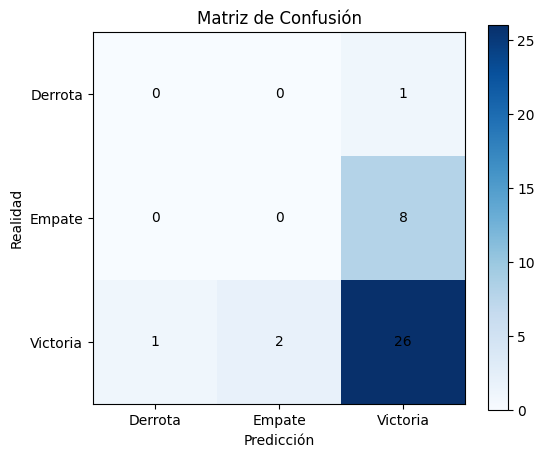

2025/03/08 13:46:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run real_madrid_logreg_seq at: https://dagshub.com/anaigs/tfg_inso_github.mlflow/#/experiments/0/runs/308edf1cd7474c40a0c8e4758bf8d80a
🧪 View experiment at: https://dagshub.com/anaigs/tfg_inso_github.mlflow/#/experiments/0


In [8]:
# Hiperparámetros del modelo
max_iter = 1000
solver = "lbfgs"

with mlflow.start_run(run_name="real_madrid_logreg_seq"):
    mlflow.log_param("model_type", "Logistic Regression")
    mlflow.log_param("approach", "Sequential Validation")
    mlflow.log_param("team", "Real Madrid")
    mlflow.log_param("max_iter", max_iter)
    mlflow.log_param("solver", solver)

    # Iterar sobre los partidos de validación de manera secuencial
    for i in range(n_validacion):
        # Entrenar el modelo con todos los partidos anteriores
        model = LogisticRegression(solver=solver, max_iter=max_iter, random_state=42)
        model.fit(X_train_scaled, y_train_init)

        # Obtener el partido a predecir
        X_next = X_val_seq.iloc[i:i+1]  
        y_next = y_val_seq.iloc[i]  

        # Escalar con los mismos parámetros del entrenamiento
        X_next_scaled = scaler.transform(X_next)

        # Predecir el partido
        y_pred_next = model.predict(X_next_scaled)[0]

        # Guardar la predicción y el resultado real
        y_pred_seq.append(y_pred_next)
        y_real_seq.append(y_next)

        # Agregar el partido actual al conjunto de entrenamiento para la siguiente iteración
        X_train_init = pd.concat([X_train_init, X_next])
        y_train_init = pd.concat([y_train_init, pd.Series([y_next])])

        # Volver a escalar los datos con la nueva información incluida
        X_train_scaled = scaler.fit_transform(X_train_init)

    # Evaluación del desempeño global
    accuracy = accuracy_score(y_real_seq, y_pred_seq)
    precision = precision_score(y_real_seq, y_pred_seq, average="weighted", zero_division=0)
    recall = recall_score(y_real_seq, y_pred_seq, average="weighted", zero_division=0)
    f1 = f1_score(y_real_seq, y_pred_seq, average="weighted", zero_division=0)

    # Registrar métricas en MLflow
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)

    # Reporte de clasificación
    report = classification_report(y_real_seq, y_pred_seq, labels=[-1, 0, 1], target_names=["Derrota (-1)", "Empate (0)", "Victoria (1)"])
    print(f"Accuracy del modelo en validación secuencial: {accuracy:.4f}")
    print("\nReporte de clasificación:\n", report)

    # Matriz de confusión
    conf_matrix = confusion_matrix(y_real_seq, y_pred_seq, labels=[-1, 0, 1])

    # Visualizar la matriz de confusión
    plt.figure(figsize=(6, 5))
    plt.imshow(conf_matrix, cmap="Blues", interpolation="nearest")
    plt.colorbar()
    plt.xticks([0, 1, 2], ["Derrota", "Empate", "Victoria"])
    plt.yticks([0, 1, 2], ["Derrota", "Empate", "Victoria"])
    plt.xlabel("Predicción")
    plt.ylabel("Realidad")
    plt.title("Matriz de Confusión")

    # Mostrar los valores dentro de la matriz
    for i in range(3):
        for j in range(3):
            plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="black")

    plt.show()

    # Guardar el modelo en MLflow
    mlflow.sklearn.log_model(model, "logistic_regression_model")

**Conclusiones del modelo con Real Madrid**

- Precisión global: 68.42%, con un buen desempeño general pero sesgado.  
- Predicción de victorias: Alta precisión y recall, el modelo detecta bien las victorias.  
- Predicción de empates y derrotas: Desempeño muy bajo, con 0% de recall en ambas categorías.  
- Desbalance de clases: El Real Madrid tiene muchas más victorias en su historial, lo que hace que el modelo aprenda a predecir victorias con más frecuencia.  
- Próximo paso: Probar con los datos de **Athletic Bilbao (`ath_bilbao.csv`)**, un equipo con una distribución de resultados más equilibrada.  


In [19]:
# Cargar los datos
file_path_bilbao = "../../datasets/datasets_equipos/ath_bilbao.csv"
df_bilbao = pd.read_csv(file_path_bilbao)

# Eliminar columnas irrelevantes
df_bilbao = df_bilbao.drop(columns=["season", "date", "team"])

# Codificar la columna 'rival_team'
label_encoder = LabelEncoder()
df_bilbao["rival_team"] = label_encoder.fit_transform(df_bilbao["rival_team"])

# Separar variables predictoras y variable objetivo
X_bilbao = df_bilbao.drop(columns=["goals_team", "goals_rival", "result"])
y_bilbao = df_bilbao["result"]  # -1 (derrota), 0 (empate), 1 (victoria)

# Definir la última temporada como validación
n_validacion = 38  # Número de partidos en una temporada
X_train_bilbao = X_bilbao.iloc[: -n_validacion]
y_train_bilbao = y_bilbao.iloc[: -n_validacion]
X_val_bilbao = X_bilbao.iloc[-n_validacion:]
y_val_bilbao = y_bilbao.iloc[-n_validacion:]

# Verificar estructura
X_train_bilbao.shape, X_val_bilbao.shape, y_train_bilbao.shape, y_val_bilbao.shape

((760, 21), (38, 21), (760,), (38,))

#### Entrenamiento y validación secuencial

- Entrenamos un modelo de **Regresión Logística** con los datos previos a cada partido.
- Predecimos partido a partido, actualizando los datos después de cada predicción.
- Evaluamos el desempeño del modelo.

In [20]:
# Definir la última temporada como validación
n_validacion = 38  
X_train_bilbao = X_bilbao.iloc[: -n_validacion]
y_train_bilbao = y_bilbao.iloc[: -n_validacion]
X_val_bilbao = X_bilbao.iloc[-n_validacion:]
y_val_bilbao = y_bilbao.iloc[-n_validacion:]

# Inicializar listas para almacenar predicciones y resultados reales
y_pred_seq_bilbao = []
y_real_seq_bilbao = []

# Escalar datos inicialmente
scaler_bilbao = StandardScaler()
X_train_scaled_bilbao = scaler_bilbao.fit_transform(X_train_bilbao)

Accuracy del modelo en validación secuencial: 0.3947

Reporte de clasificación:
               precision    recall  f1-score   support

Derrota (-1)       0.31      1.00      0.47         8
  Empate (0)       0.00      0.00      0.00        11
Victoria (1)       0.70      0.37      0.48        19

    accuracy                           0.39        38
   macro avg       0.34      0.46      0.32        38
weighted avg       0.41      0.39      0.34        38



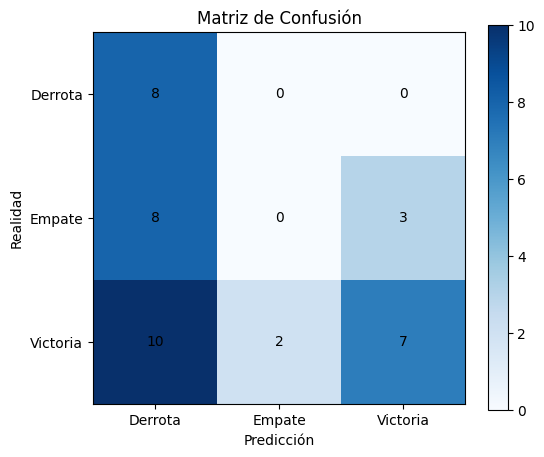

🏃 View run athletic_bilbao_logreg_seq at: https://dagshub.com/anaigs/tfg_inso_github.mlflow/#/experiments/0/runs/95d2724a62a143f298ae4c722e075f79
🧪 View experiment at: https://dagshub.com/anaigs/tfg_inso_github.mlflow/#/experiments/0


In [11]:
# Hiperparámetros del modelo
max_iter = 1000
solver = "lbfgs"

with mlflow.start_run(run_name="athletic_bilbao_logreg_seq"):
    mlflow.log_param("model_type", "Logistic Regression")
    mlflow.log_param("approach", "Sequential Validation")
    mlflow.log_param("team", "Athletic Bilbao")
    mlflow.log_param("max_iter", max_iter)
    mlflow.log_param("solver", solver)

    # Iterar sobre los partidos de validación de manera secuencial
    for i in range(n_validacion):
        # Entrenar el modelo con todos los partidos anteriores
        model_bilbao = LogisticRegression(solver=solver, max_iter=max_iter, random_state=42)
        model_bilbao.fit(X_train_scaled_bilbao, y_train_bilbao)

        # Obtener el partido a predecir
        X_next_bilbao = X_val_bilbao.iloc[i:i+1]
        y_next_bilbao = y_val_bilbao.iloc[i]

        # Escalar con los mismos parámetros del entrenamiento
        X_next_scaled_bilbao = scaler_bilbao.transform(X_next_bilbao)

        # Predecir el partido
        y_pred_next_bilbao = model_bilbao.predict(X_next_scaled_bilbao)[0]

        # Guardar la predicción y el resultado real
        y_pred_seq_bilbao.append(y_pred_next_bilbao)
        y_real_seq_bilbao.append(y_next_bilbao)

        # Agregar el partido actual al conjunto de entrenamiento para la siguiente iteración
        X_train_bilbao = pd.concat([X_train_bilbao, X_next_bilbao])
        y_train_bilbao = pd.concat([y_train_bilbao, pd.Series([y_next_bilbao])])

        # Volver a escalar los datos con la nueva información incluida
        X_train_scaled_bilbao = scaler_bilbao.fit_transform(X_train_bilbao)

    # Evaluación del desempeño global
    accuracy_bilbao = accuracy_score(y_real_seq_bilbao, y_pred_seq_bilbao)
    precision_bilbao = precision_score(y_real_seq_bilbao, y_pred_seq_bilbao, average="weighted", zero_division=0)
    recall_bilbao = recall_score(y_real_seq_bilbao, y_pred_seq_bilbao, average="weighted", zero_division=0)
    f1_bilbao = f1_score(y_real_seq_bilbao, y_pred_seq_bilbao, average="weighted", zero_division=0)

    # Registrar métricas en MLflow
    mlflow.log_metric("accuracy", accuracy_bilbao)
    mlflow.log_metric("precision", precision_bilbao)
    mlflow.log_metric("recall", recall_bilbao)
    mlflow.log_metric("f1_score", f1_bilbao)

    # Reporte de clasificación
    report_bilbao = classification_report(y_real_seq_bilbao, y_pred_seq_bilbao, labels=[-1, 0, 1], target_names=["Derrota (-1)", "Empate (0)", "Victoria (1)"])
    print(f"Accuracy del modelo en validación secuencial: {accuracy_bilbao:.4f}")
    print("\nReporte de clasificación:\n", report_bilbao)

    # Matriz de confusión
    conf_matrix_bilbao = confusion_matrix(y_real_seq_bilbao, y_pred_seq_bilbao, labels=[-1, 0, 1])

    # Visualizar la matriz de confusión
    plt.figure(figsize=(6, 5))
    plt.imshow(conf_matrix_bilbao, cmap="Blues", interpolation="nearest")
    plt.colorbar()
    plt.xticks([0, 1, 2], ["Derrota", "Empate", "Victoria"])
    plt.yticks([0, 1, 2], ["Derrota", "Empate", "Victoria"])
    plt.xlabel("Predicción")
    plt.ylabel("Realidad")
    plt.title("Matriz de Confusión")

    # Mostrar los valores dentro de la matriz
    for i in range(3):
        for j in range(3):
            plt.text(j, i, conf_matrix_bilbao[i, j], ha="center", va="center", color="black")

    plt.show()

**Conclusiones del modelo con Athletic Bilbao**

- Precisión global: 39.47%, menor que con Real Madrid, indicando mayor dificultad para predecir correctamente.  
- Predicción de derrotas: Muy precisa (100% recall), pero puede indicar un sesgo excesivo hacia esta clase.  
- Predicción de empates: Totalmente fallida, con 0% de recall y precisión.  
- Predicción de victorias: Moderada, con un recall del 37%, indicando que muchas victorias fueron clasificadas erróneamente.  
- Desbalance en predicciones: El modelo predice demasiadas derrotas y pocas victorias y empates, lo que sugiere la necesidad de mejorar el balance de clases o ajustar hiperparámetros.  
- Próximo paso:** Probar estrategias de balanceo de clases

#### Balanceo de clases

- Se observa que el modelo tiende a favorecer una clase sobre las demás.  
- Para corregir esto, se aplicará **oversampling** en las clases menos representadas usando `SMOTE`.  
- Se volverá a entrenar el modelo y se evaluará si mejora la precisión en empates y victorias.  


In [15]:
# Cargar los datos
file_path_bilbao = "../../datasets/datasets_equipos/ath_bilbao.csv"
df_bilbao = pd.read_csv(file_path_bilbao)

# Preprocesamiento
df_bilbao = df_bilbao.drop(columns=["season", "date", "team"])
label_encoder = LabelEncoder()
df_bilbao["rival_team"] = label_encoder.fit_transform(df_bilbao["rival_team"])

# Separar variables predictoras y variable objetivo
X_bilbao = df_bilbao.drop(columns=["goals_team", "goals_rival", "result"])
y_bilbao = df_bilbao["result"]  # -1 (derrota), 0 (empate), 1 (victoria)

# Definir la última temporada como validación
n_validacion = 38  
X_train_bilbao = X_bilbao.iloc[: -n_validacion]
y_train_bilbao = y_bilbao.iloc[: -n_validacion]
X_val_bilbao = X_bilbao.iloc[-n_validacion:]
y_val_bilbao = y_bilbao.iloc[-n_validacion:]

In [16]:
from imblearn.over_sampling import SMOTE

# Aplicar SMOTE para balancear las clases en el conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_bilbao, y_train_bilbao)

# Verificar distribución de clases después del balanceo
y_train_balanced.value_counts()

result
-1    279
 1    279
 0    279
Name: count, dtype: int64

#### Entrenamiento y validación con datos balanceados

- Se entrena el modelo con el nuevo conjunto balanceado.  
- Se repite el proceso de validación secuencial con los partidos de la última temporada.  


Accuracy del modelo con balanceo de clases: 0.3684

Reporte de clasificación:
               precision    recall  f1-score   support

Derrota (-1)       0.26      0.62      0.37         8
  Empate (0)       0.27      0.27      0.27        11
Victoria (1)       0.75      0.32      0.44        19

    accuracy                           0.37        38
   macro avg       0.43      0.40      0.36        38
weighted avg       0.51      0.37      0.38        38



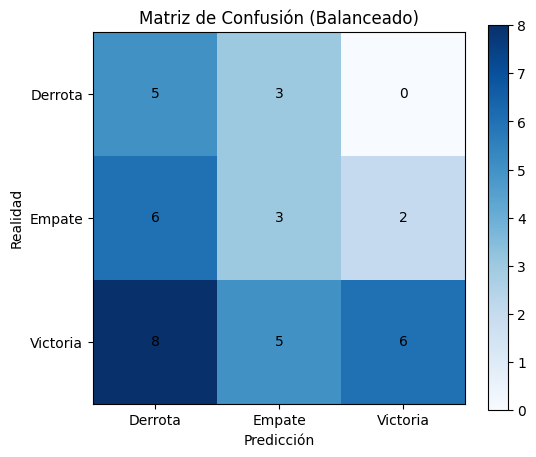

🏃 View run athletic_bilbao_logreg_balanced at: https://dagshub.com/anaigs/tfg_inso_github.mlflow/#/experiments/0/runs/2b40166fa89e4b149db35a838990370c
🧪 View experiment at: https://dagshub.com/anaigs/tfg_inso_github.mlflow/#/experiments/0


In [ ]:
# Inicializar listas para almacenar predicciones y resultados reales
y_pred_seq_balanced = []
y_real_seq_balanced = []

# Escalar los datos balanceados
scaler_balanced = StandardScaler()
X_train_scaled_balanced = scaler_balanced.fit_transform(X_train_balanced)

# Hiperparámetros del modelo
max_iter = 1000
solver = "lbfgs"

with mlflow.start_run(run_name="athletic_bilbao_logreg_balanced"):
    mlflow.log_param("model_type", "Logistic Regression")
    mlflow.log_param("approach", "Sequential Validation + Class Balancing (SMOTE)")
    mlflow.log_param("team", "Athletic Bilbao")
    mlflow.log_param("max_iter", max_iter)
    mlflow.log_param("solver", solver)

    # Iterar sobre los partidos de validación
    for i in range(n_validacion):
        # Entrenar el modelo con el conjunto balanceado
        model_balanced = LogisticRegression(solver=solver, max_iter=max_iter, random_state=42)
        model_balanced.fit(X_train_scaled_balanced, y_train_balanced)

        # Obtener el partido a predecir
        X_next_balanced = X_val_bilbao.iloc[i:i+1]
        y_next_balanced = y_val_bilbao.iloc[i]

        # Escalar con los mismos parámetros del entrenamiento
        X_next_scaled_balanced = scaler_balanced.transform(X_next_balanced)

        # Predecir el partido
        y_pred_next_balanced = model_balanced.predict(X_next_scaled_balanced)[0]

        # Guardar la predicción y el resultado real
        y_pred_seq_balanced.append(y_pred_next_balanced)
        y_real_seq_balanced.append(y_next_balanced)

        # Agregar el partido actual al conjunto de entrenamiento
        X_train_balanced = pd.concat([pd.DataFrame(X_train_balanced, columns=X_train_bilbao.columns), X_next_balanced])
        y_train_balanced = pd.concat([pd.Series(y_train_balanced), pd.Series([y_next_balanced])])

        # Volver a escalar los datos con la nueva información incluida
        X_train_scaled_balanced = scaler_balanced.fit_transform(X_train_balanced)

    # Evaluación del desempeño con datos balanceados
    accuracy_balanced = accuracy_score(y_real_seq_balanced, y_pred_seq_balanced)
    precision_balanced = precision_score(y_real_seq_balanced, y_pred_seq_balanced, average="weighted", zero_division=0)
    recall_balanced = recall_score(y_real_seq_balanced, y_pred_seq_balanced, average="weighted", zero_division=0)
    f1_balanced = f1_score(y_real_seq_balanced, y_pred_seq_balanced, average="weighted", zero_division=0)

    # Registrar métricas en MLflow
    mlflow.log_metric("accuracy", accuracy_balanced)
    mlflow.log_metric("precision", precision_balanced)
    mlflow.log_metric("recall", recall_balanced)
    mlflow.log_metric("f1_score", f1_balanced)

    # Reporte de clasificación
    report_balanced = classification_report(y_real_seq_balanced, y_pred_seq_balanced, labels=[-1, 0, 1], target_names=["Derrota (-1)", "Empate (0)", "Victoria (1)"])
    print(f"Accuracy del modelo con balanceo de clases: {accuracy_balanced:.4f}")
    print("\nReporte de clasificación:\n", report_balanced)

    # Matriz de confusión
    conf_matrix_balanced = confusion_matrix(y_real_seq_balanced, y_pred_seq_balanced, labels=[-1, 0, 1])

    # Visualizar la matriz de confusión
    plt.figure(figsize=(6, 5))
    plt.imshow(conf_matrix_balanced, cmap="Blues", interpolation="nearest")
    plt.colorbar()
    plt.xticks([0, 1, 2], ["Derrota", "Empate", "Victoria"])
    plt.yticks([0, 1, 2], ["Derrota", "Empate", "Victoria"])
    plt.xlabel("Predicción")
    plt.ylabel("Realidad")
    plt.title("Matriz de Confusión (Balanceado)")

    # Mostrar los valores dentro de la matriz
    for i in range(3):
        for j in range(3):
            plt.text(j, i, conf_matrix_balanced[i, j], ha="center", va="center", color="black")

    plt.show()

**Conclusiones del modelo con Athletic Bilbao (Balanceo de Clases - SMOTE)**  

- Precisión global: 36.84%, ligeramente menor que en la versión sin balanceo (39.47%), lo que indica que el balanceo de clases con SMOTE no mejoró el rendimiento general.  
- Predicción de derrotas: Recall del 62%, superior a la versión sin balanceo, pero con precisión baja (26%), lo que sugiere que el modelo está prediciendo muchas derrotas incorrectamente.  
- Predicción de empates: Sigue siendo muy baja (27% recall, 27% precisión), lo que indica que el modelo aún tiene dificultades para identificar correctamente los partidos empatados.  
- Predicción de victorias: Recall del 32%, peor que la versión sin balanceo (37%), lo que indica que el modelo sigue clasificando erróneamente muchas victorias como derrotas o empates.  
- Desbalance en predicciones: El modelo sigue favoreciendo las derrotas y fallando en empates y victorias, lo que sugiere que SMOTE podría no ser la mejor estrategia de balanceo en este caso.  
- Próximo paso: Explorar técnicas alternativas de balanceo de clases como undersampling

In [24]:
from imblearn.under_sampling import RandomUnderSampler

# Definir la última temporada como validación
n_validacion = 38  
X_train_bilbao = X_bilbao.iloc[: -n_validacion]
y_train_bilbao = y_bilbao.iloc[: -n_validacion]
X_val_bilbao = X_bilbao.iloc[-n_validacion:]
y_val_bilbao = y_bilbao.iloc[-n_validacion:]

# Aplicar Random Undersampling para balancear las clases en el conjunto de entrenamiento
undersampler = RandomUnderSampler(random_state=42)
X_train_balanced, y_train_balanced = undersampler.fit_resample(X_train_bilbao, y_train_bilbao)

# Inicializar listas para almacenar predicciones y resultados reales
y_pred_seq_balanced = []
y_real_seq_balanced = []

# Escalar los datos balanceados
scaler_balanced = StandardScaler()
X_train_scaled_balanced = scaler_balanced.fit_transform(X_train_balanced)



Accuracy del modelo con undersampling: 0.4211

Reporte de clasificación:
               precision    recall  f1-score   support

Derrota (-1)       0.41      0.88      0.56         8
  Empate (0)       0.31      0.36      0.33        11
Victoria (1)       0.62      0.26      0.37        19

    accuracy                           0.42        38
   macro avg       0.45      0.50      0.42        38
weighted avg       0.49      0.42      0.40        38



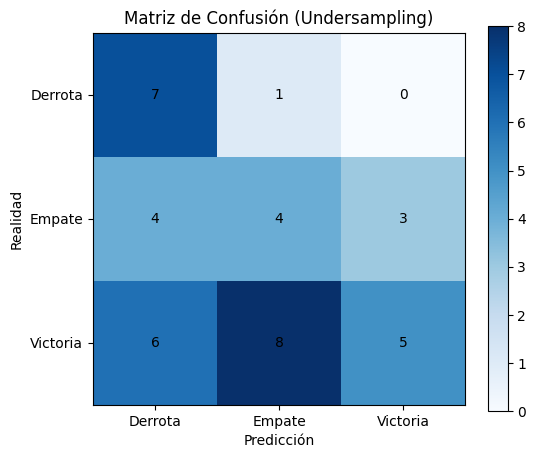

🏃 View run athletic_bilbao_logreg_undersampling at: https://dagshub.com/anaigs/tfg_inso_github.mlflow/#/experiments/0/runs/c865ea4c71584d8a9753d47e85e12741
🧪 View experiment at: https://dagshub.com/anaigs/tfg_inso_github.mlflow/#/experiments/0


In [25]:
# Hiperparámetros del modelo
max_iter = 1000
solver = "lbfgs"

with mlflow.start_run(run_name="athletic_bilbao_logreg_undersampling"):
    mlflow.log_param("model_type", "Logistic Regression")
    mlflow.log_param("approach", "Sequential Validation + Undersampling")
    mlflow.log_param("team", "Athletic Bilbao")
    mlflow.log_param("max_iter", max_iter)
    mlflow.log_param("solver", solver)

    # Iterar sobre los partidos de validación
    for i in range(n_validacion):
        # Entrenar el modelo con el conjunto balanceado
        model_balanced = LogisticRegression(solver=solver, max_iter=max_iter, random_state=42)
        model_balanced.fit(X_train_scaled_balanced, y_train_balanced)

        # Obtener el partido a predecir
        X_next_balanced = X_val_bilbao.iloc[i:i+1]
        y_next_balanced = y_val_bilbao.iloc[i]

        # Escalar con los mismos parámetros del entrenamiento
        X_next_scaled_balanced = scaler_balanced.transform(X_next_balanced)

        # Predecir el partido
        y_pred_next_balanced = model_balanced.predict(X_next_scaled_balanced)[0]

        # Guardar la predicción y el resultado real
        y_pred_seq_balanced.append(y_pred_next_balanced)
        y_real_seq_balanced.append(y_next_balanced)

        # Agregar el partido actual al conjunto de entrenamiento
        X_train_balanced = pd.concat([pd.DataFrame(X_train_balanced, columns=X_train_bilbao.columns), X_next_balanced])
        y_train_balanced = pd.concat([pd.Series(y_train_balanced), pd.Series([y_next_balanced])])

        # Volver a escalar los datos con la nueva información incluida
        X_train_scaled_balanced = scaler_balanced.fit_transform(X_train_balanced)

    # Evaluación del desempeño con undersampling
    accuracy_balanced = accuracy_score(y_real_seq_balanced, y_pred_seq_balanced)
    precision_balanced = precision_score(y_real_seq_balanced, y_pred_seq_balanced, average="weighted", zero_division=0)
    recall_balanced = recall_score(y_real_seq_balanced, y_pred_seq_balanced, average="weighted", zero_division=0)
    f1_balanced = f1_score(y_real_seq_balanced, y_pred_seq_balanced, average="weighted", zero_division=0)

    # Registrar métricas en MLflow
    mlflow.log_metric("accuracy", accuracy_balanced)
    mlflow.log_metric("precision", precision_balanced)
    mlflow.log_metric("recall", recall_balanced)
    mlflow.log_metric("f1_score", f1_balanced)

    # Reporte de clasificación
    report_balanced = classification_report(y_real_seq_balanced, y_pred_seq_balanced, labels=[-1, 0, 1], target_names=["Derrota (-1)", "Empate (0)", "Victoria (1)"])
    print(f"Accuracy del modelo con undersampling: {accuracy_balanced:.4f}")
    print("\nReporte de clasificación:\n", report_balanced)

    # Matriz de confusión
    conf_matrix_balanced = confusion_matrix(y_real_seq_balanced, y_pred_seq_balanced, labels=[-1, 0, 1])

    # Visualizar la matriz de confusión
    plt.figure(figsize=(6, 5))
    plt.imshow(conf_matrix_balanced, cmap="Blues", interpolation="nearest")
    plt.colorbar()
    plt.xticks([0, 1, 2], ["Derrota", "Empate", "Victoria"])
    plt.yticks([0, 1, 2], ["Derrota", "Empate", "Victoria"])
    plt.xlabel("Predicción")
    plt.ylabel("Realidad")
    plt.title("Matriz de Confusión (Undersampling)")

    # Mostrar los valores dentro de la matriz
    for i in range(3):
        for j in range(3):
            plt.text(j, i, conf_matrix_balanced[i, j], ha="center", va="center", color="black")

    plt.show()


**Conclusiones del modelo con Athletic Bilbao (Undersampling)**  

- Precisión global: 42.11%, superior al modelo con SMOTE (36.84%), indicando que el undersampling permitió una mejor generalización del modelo.  
- Predicción de derrotas: Muy precisa, con 88% de recall y 41% de precisión, lo que significa que el modelo identifica correctamente la mayoría de las derrotas pero aún tiene problemas con falsos positivos.  
- Predicción de empates: Mejor que en modelos anteriores (36% recall, 31% precisión), pero sigue siendo la categoría más difícil de predecir.  
- Predicción de victorias: 26% de recall, menor que con SMOTE (32%), indicando que el modelo sigue clasificando muchas victorias como derrotas o empates.  
- Desbalance en predicciones: El modelo sigue favoreciendo derrotas y empates, aunque la distribución es más equilibrada que con SMOTE.  

#### Posibles problemas con muchas columnas en Regresión Logística

- **Sobreajuste:** Un número alto de variables puede hacer que el modelo aprenda patrones espurios en lugar de tendencias generales.  
- **Multicolinealidad:** Si algunas columnas están altamente correlacionadas, el modelo puede volverse inestable.  
- **Dificultad en la optimización:** Regresión Logística es más efectiva con conjuntos de datos más simples y puede tener problemas cuando hay muchas variables irrelevantes.  


#### Selección de características

- Se utilizará **SelectFromModel** con **Regresión Logística** para identificar las características más importantes.  
- Se entrenará el modelo con solo estas variables y se evaluará su desempeño.  
- Esto ayudará a reducir el impacto del sobreajuste y mejorar la interpretabilidad.  


In [ ]:
from sklearn.feature_selection import SelectFromModel

# Entrenar un modelo inicial de Regresión Logística para la selección de características
selector = SelectFromModel(estimator=LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42))
selector.fit(X_train_scaled_balanced, y_train_balanced)

# Obtener las características seleccionadas
selected_features = X_train_bilbao.columns[selector.get_support()]
print("Características seleccionadas:", list(selected_features))

# Reducir el dataset a solo las características importantes
X_train_selected = selector.transform(X_train_scaled_balanced)
X_val_selected = selector.transform(scaler_balanced.transform(X_val_bilbao))

#### Entrenamiento y evaluación con características seleccionadas

- Se reentrena el modelo con las características más relevantes.  
- Se evalúa si la reducción de variables mejora la precisión y estabilidad del modelo.  

In [27]:
from sklearn.feature_selection import SelectFromModel

# Definir la última temporada como validación
n_validacion = 38  
X_train_bilbao = X_bilbao.iloc[: -n_validacion]
y_train_bilbao = y_bilbao.iloc[: -n_validacion]
X_val_bilbao = X_bilbao.iloc[-n_validacion:]
y_val_bilbao = y_bilbao.iloc[-n_validacion:]

# Aplicar Random Undersampling para balancear las clases
undersampler = RandomUnderSampler(random_state=42)
X_train_balanced, y_train_balanced = undersampler.fit_resample(X_train_bilbao, y_train_bilbao)

# Escalar los datos balanceados
scaler_balanced = StandardScaler()
X_train_scaled_balanced = scaler_balanced.fit_transform(X_train_balanced)

# Selección de características con Regresión Logística
selector = SelectFromModel(estimator=LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42))
selector.fit(X_train_scaled_balanced, y_train_balanced)

# Obtener las características seleccionadas
selected_features = X_train_bilbao.columns[selector.get_support()]
print("Características seleccionadas:", list(selected_features))

# Transformar los datos con las características seleccionadas
X_train_selected = selector.transform(X_train_scaled_balanced)
X_val_selected = selector.transform(scaler_balanced.transform(X_val_bilbao))

# Inicializar listas para almacenar predicciones y resultados reales
y_pred_seq_selected = []
y_real_seq_selected = []

Características seleccionadas: ['avg_goals_scored', 'pct_wins_vs_rival', 'AvgWin', 'AvgLoss', 'AvgAHWin']


Accuracy del modelo con selección de características: 0.3947

Reporte de clasificación:
               precision    recall  f1-score   support

Derrota (-1)       0.36      0.62      0.45         8
  Empate (0)       0.23      0.27      0.25        11
Victoria (1)       0.64      0.37      0.47        19

    accuracy                           0.39        38
   macro avg       0.41      0.42      0.39        38
weighted avg       0.46      0.39      0.40        38



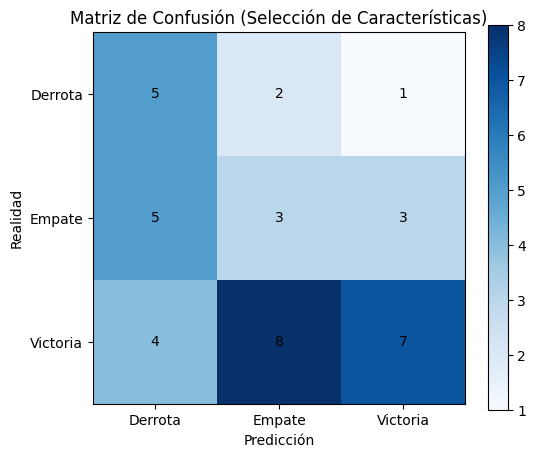

🏃 View run athletic_bilbao_logreg_feat_selection at: https://dagshub.com/anaigs/tfg_inso_github.mlflow/#/experiments/0/runs/6f447a50a9254fdc8725581d62e677e5
🧪 View experiment at: https://dagshub.com/anaigs/tfg_inso_github.mlflow/#/experiments/0


In [28]:

# Hiperparámetros del modelo
max_iter = 1000
solver = "lbfgs"

with mlflow.start_run(run_name="athletic_bilbao_logreg_feat_selection"):
    mlflow.log_param("model_type", "Logistic Regression")
    mlflow.log_param("approach", "Sequential Validation + Undersampling + Feature Selection")
    mlflow.log_param("team", "Athletic Bilbao")
    mlflow.log_param("max_iter", max_iter)
    mlflow.log_param("solver", solver)
    mlflow.log_param("selected_features", list(selected_features))

    # Iterar sobre los partidos de validación
    for i in range(n_validacion):
        # Entrenar el modelo con las características seleccionadas
        model_selected = LogisticRegression(solver=solver, max_iter=max_iter, random_state=42)
        model_selected.fit(X_train_selected, y_train_balanced)

        # Obtener el partido a predecir
        X_next_selected = X_val_selected[i:i+1]
        y_next_selected = y_val_bilbao.iloc[i]

        # Predecir el partido
        y_pred_next_selected = model_selected.predict(X_next_selected)[0]

        # Guardar la predicción y el resultado real
        y_pred_seq_selected.append(y_pred_next_selected)
        y_real_seq_selected.append(y_next_selected)

        # Agregar el partido actual al conjunto de entrenamiento
        X_train_selected = np.vstack([X_train_selected, X_next_selected])
        y_train_balanced = pd.concat([pd.Series(y_train_balanced), pd.Series([y_next_selected])])

    # Evaluación del modelo con características seleccionadas
    accuracy_selected = accuracy_score(y_real_seq_selected, y_pred_seq_selected)
    precision_selected = precision_score(y_real_seq_selected, y_pred_seq_selected, average="weighted", zero_division=0)
    recall_selected = recall_score(y_real_seq_selected, y_pred_seq_selected, average="weighted", zero_division=0)
    f1_selected = f1_score(y_real_seq_selected, y_pred_seq_selected, average="weighted", zero_division=0)

    # Registrar métricas en MLflow
    mlflow.log_metric("accuracy", accuracy_selected)
    mlflow.log_metric("precision", precision_selected)
    mlflow.log_metric("recall", recall_selected)
    mlflow.log_metric("f1_score", f1_selected)

    # Reporte de clasificación
    report_selected = classification_report(y_real_seq_selected, y_pred_seq_selected, labels=[-1, 0, 1], target_names=["Derrota (-1)", "Empate (0)", "Victoria (1)"])
    print(f"Accuracy del modelo con selección de características: {accuracy_selected:.4f}")
    print("\nReporte de clasificación:\n", report_selected)

    # Matriz de confusión
    conf_matrix_selected = confusion_matrix(y_real_seq_selected, y_pred_seq_selected, labels=[-1, 0, 1])

    # Visualizar la matriz de confusión
    plt.figure(figsize=(6, 5))
    plt.imshow(conf_matrix_selected, cmap="Blues", interpolation="nearest")
    plt.colorbar()
    plt.xticks([0, 1, 2], ["Derrota", "Empate", "Victoria"])
    plt.yticks([0, 1, 2], ["Derrota", "Empate", "Victoria"])
    plt.xlabel("Predicción")
    plt.ylabel("Realidad")
    plt.title("Matriz de Confusión (Selección de Características)")

    # Mostrar los valores dentro de la matriz
    for i in range(3):
        for j in range(3):
            plt.text(j, i, conf_matrix_selected[i, j], ha="center", va="center", color="black")

    plt.show()

#### Conclusiones tras la selección de características

- **Precisión global:** 39.47%, sin mejoras significativas respecto al modelo anterior.  
- **Predicción de derrotas y empates:** Ligera mejora en recall, pero sigue con baja precisión.  
- **Predicción de victorias:** Ha bajado su desempeño, con menor recall.  
- **Impacto de la selección de características:** No ha mejorado la precisión general, lo que indica que el problema no era solo el exceso de variables.  
- **Próximo paso:** Explorar reducción de dimensionalidad con **PCA**

#### Reducción de dimensionalidad con PCA

- Se aplicará **PCA (Análisis de Componentes Principales)** para reducir la dimensionalidad del dataset.  
- PCA transforma los datos en nuevas variables ortogonales que capturan la mayor varianza posible.  
- Se mantendrán suficientes componentes para conservar al menos el **95% de la varianza** original.  


In [30]:
from sklearn.decomposition import PCA


# Definir la última temporada como validación
n_validacion = 38  
X_train_bilbao = X_bilbao.iloc[: -n_validacion]
y_train_bilbao = y_bilbao.iloc[: -n_validacion]
X_val_bilbao = X_bilbao.iloc[-n_validacion:]
y_val_bilbao = y_bilbao.iloc[-n_validacion:]

# Aplicar Random Undersampling para balancear las clases
undersampler = RandomUnderSampler(random_state=42)
X_train_balanced, y_train_balanced = undersampler.fit_resample(X_train_bilbao, y_train_bilbao)

# Escalar los datos balanceados
scaler_balanced = StandardScaler()
X_train_scaled_balanced = scaler_balanced.fit_transform(X_train_balanced)

# Aplicar PCA manteniendo el 95% de la varianza
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled_balanced)
X_val_pca = pca.transform(scaler_balanced.transform(X_val_bilbao))

# Mostrar el número de componentes seleccionados
n_components = pca.n_components_
print(f"Número de componentes principales retenidos: {n_components}")

# Inicializar listas para almacenar predicciones y resultados reales
y_pred_seq_pca = []
y_real_seq_pca = []



Número de componentes principales retenidos: 14


Accuracy del modelo con PCA: 0.4474

Reporte de clasificación:
               precision    recall  f1-score   support

Derrota (-1)       0.60      0.75      0.67         8
  Empate (0)       0.30      0.55      0.39        11
Victoria (1)       0.62      0.26      0.37        19

    accuracy                           0.45        38
   macro avg       0.51      0.52      0.47        38
weighted avg       0.53      0.45      0.44        38



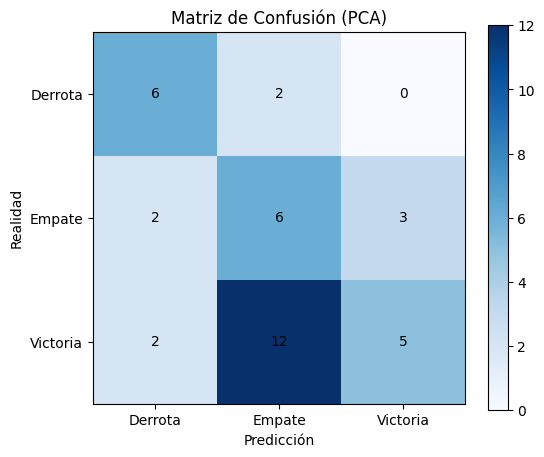

🏃 View run athletic_bilbao_logreg_pca at: https://dagshub.com/anaigs/tfg_inso_github.mlflow/#/experiments/0/runs/6fc1a2bc81c546b0bc48a13ea7f0320e
🧪 View experiment at: https://dagshub.com/anaigs/tfg_inso_github.mlflow/#/experiments/0


In [31]:

# Hiperparámetros del modelo
max_iter = 1000
solver = "lbfgs"

with mlflow.start_run(run_name="athletic_bilbao_logreg_pca"):
    mlflow.log_param("model_type", "Logistic Regression")
    mlflow.log_param("approach", "Sequential Validation + Undersampling + PCA")
    mlflow.log_param("team", "Athletic Bilbao")
    mlflow.log_param("max_iter", max_iter)
    mlflow.log_param("solver", solver)
    mlflow.log_param("pca_n_components", n_components)

    # Ajustar dimensiones de entrenamiento
    min_samples = min(X_train_pca.shape[0], y_train_balanced.shape[0])
    X_train_pca_seq = X_train_pca[:min_samples]
    y_train_pca_seq = np.array(y_train_balanced[:min_samples])

    # Iterar sobre los partidos de validación
    for i in range(n_validacion):
        # Entrenar el modelo con los datos transformados por PCA
        model_pca = LogisticRegression(solver=solver, max_iter=max_iter, random_state=42)
        model_pca.fit(X_train_pca_seq, y_train_pca_seq)

        # Obtener el partido a predecir
        X_next_pca = X_val_pca[i:i+1]
        y_next_pca = y_val_bilbao.iloc[i]

        # Predecir el partido
        y_pred_next_pca = model_pca.predict(X_next_pca)[0]

        # Guardar la predicción y el resultado real
        y_pred_seq_pca.append(y_pred_next_pca)
        y_real_seq_pca.append(y_next_pca)

        # Agregar el partido actual al conjunto de entrenamiento
        X_train_pca_seq = np.vstack([X_train_pca_seq, X_next_pca])
        y_train_pca_seq = np.append(y_train_pca_seq, y_next_pca)

    # Evaluación del modelo con PCA
    accuracy_pca = accuracy_score(y_real_seq_pca, y_pred_seq_pca)
    precision_pca = precision_score(y_real_seq_pca, y_pred_seq_pca, average="weighted", zero_division=0)
    recall_pca = recall_score(y_real_seq_pca, y_pred_seq_pca, average="weighted", zero_division=0)
    f1_pca = f1_score(y_real_seq_pca, y_pred_seq_pca, average="weighted", zero_division=0)

    # Registrar métricas en MLflow
    mlflow.log_metric("accuracy", accuracy_pca)
    mlflow.log_metric("precision", precision_pca)
    mlflow.log_metric("recall", recall_pca)
    mlflow.log_metric("f1_score", f1_pca)

    # Reporte de clasificación
    report_pca = classification_report(y_real_seq_pca, y_pred_seq_pca, labels=[-1, 0, 1], target_names=["Derrota (-1)", "Empate (0)", "Victoria (1)"])
    print(f"Accuracy del modelo con PCA: {accuracy_pca:.4f}")
    print("\nReporte de clasificación:\n", report_pca)

    # Matriz de confusión
    conf_matrix_pca = confusion_matrix(y_real_seq_pca, y_pred_seq_pca, labels=[-1, 0, 1])

    # Visualizar la matriz de confusión
    plt.figure(figsize=(6, 5))
    plt.imshow(conf_matrix_pca, cmap="Blues", interpolation="nearest")
    plt.colorbar()
    plt.xticks([0, 1, 2], ["Derrota", "Empate", "Victoria"])
    plt.yticks([0, 1, 2], ["Derrota", "Empate", "Victoria"])
    plt.xlabel("Predicción")
    plt.ylabel("Realidad")
    plt.title("Matriz de Confusión (PCA)")

    # Mostrar los valores dentro de la matriz
    for i in range(3):
        for j in range(3):
            plt.text(j, i, conf_matrix_pca[i, j], ha="center", va="center", color="black")

    plt.show()

**Conclusiones del modelo con Athletic Bilbao (PCA)**  

- Precisión global: 44.74%, la mejor hasta ahora en comparación con los modelos anteriores, lo que indica que la reducción de dimensionalidad con PCA ha sido beneficiosa.  
- Predicción de derrotas: Muy buena, con un recall del 75% y precisión del 60%, lo que significa que el modelo identifica correctamente la mayoría de las derrotas y con menos falsos positivos.  
- Predicción de empates: Ha mejorado en recall (55%) respecto a modelos previos, aunque la precisión sigue siendo baja (30%), lo que indica que el modelo aún confunde empates con otras clases.  
- Predicción de victorias: Recall del 26%, lo que significa que sigue teniendo problemas al identificar victorias correctamente, aunque mantiene una precisión del 62%, lo que indica que cuando predice una victoria, es más confiable.  
- Impacto del PCA: La reducción de dimensionalidad ha mejorado el desempeño general del modelo, logrando un mejor balance entre clases sin comprometer significativamente la precisión. Esto sugiere que PCA ha ayudado a eliminar información redundante, permitiendo que el modelo capture mejor las relaciones clave en los datos.  

#### Probar esta técnica con el resto de equipos 

In [36]:
# Lista de equipos a analizar
equipos = {
    "real_madrid": "../../datasets/datasets_equipos/real_madrid.csv",
    "barcelona": "../../datasets/datasets_equipos/barcelona.csv",
    "valencia": "../../datasets/datasets_equipos/valencia.csv"
}

# Parámetros globales del modelo
n_validacion = 38  # Última temporada como validación
max_iter = 1000
solver = "lbfgs"


Procesando equipo: real_madrid
Número de componentes principales retenidos para real_madrid: 14
Accuracy del modelo con PCA para real_madrid: 0.5000

Reporte de clasificación:
               precision    recall  f1-score   support

Derrota (-1)       0.00      0.00      0.00         1
  Empate (0)       0.30      0.88      0.45         8
Victoria (1)       0.92      0.41      0.57        29

    accuracy                           0.50        38
   macro avg       0.41      0.43      0.34        38
weighted avg       0.77      0.50      0.53        38



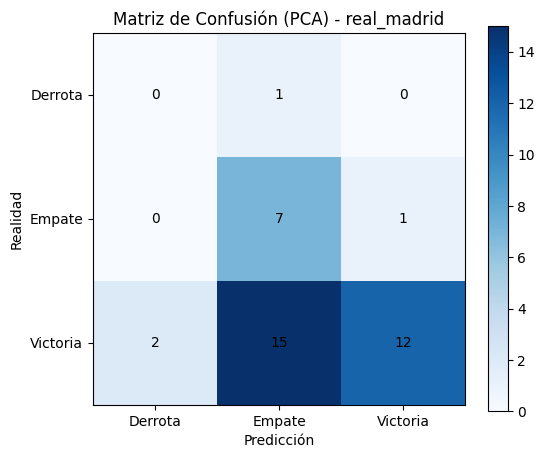

🏃 View run real_madrid_logreg_pca at: https://dagshub.com/anaigs/tfg_inso_github.mlflow/#/experiments/0/runs/279e160b8efe4fe0a1e8c17120e21cd3
🧪 View experiment at: https://dagshub.com/anaigs/tfg_inso_github.mlflow/#/experiments/0

Procesando equipo: barcelona
Número de componentes principales retenidos para barcelona: 14
Accuracy del modelo con PCA para barcelona: 0.3421

Reporte de clasificación:
               precision    recall  f1-score   support

Derrota (-1)       0.20      0.80      0.32         5
  Empate (0)       0.33      0.57      0.42         7
Victoria (1)       0.83      0.19      0.31        26

    accuracy                           0.34        38
   macro avg       0.46      0.52      0.35        38
weighted avg       0.66      0.34      0.33        38



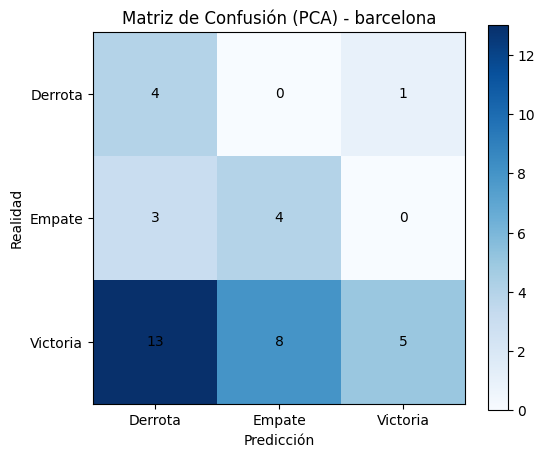

🏃 View run barcelona_logreg_pca at: https://dagshub.com/anaigs/tfg_inso_github.mlflow/#/experiments/0/runs/d9b64eb028ed448e96c4f18f110e9f3e
🧪 View experiment at: https://dagshub.com/anaigs/tfg_inso_github.mlflow/#/experiments/0

Procesando equipo: valencia
Número de componentes principales retenidos para valencia: 14
Accuracy del modelo con PCA para valencia: 0.5526

Reporte de clasificación:
               precision    recall  f1-score   support

Derrota (-1)       0.55      0.73      0.63        15
  Empate (0)       0.42      0.50      0.45        10
Victoria (1)       0.83      0.38      0.53        13

    accuracy                           0.55        38
   macro avg       0.60      0.54      0.54        38
weighted avg       0.61      0.55      0.55        38



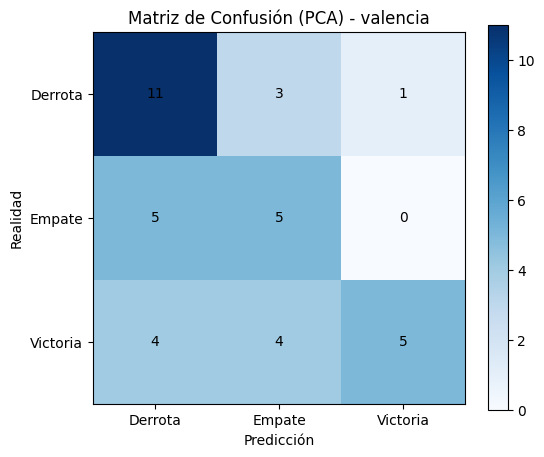

🏃 View run valencia_logreg_pca at: https://dagshub.com/anaigs/tfg_inso_github.mlflow/#/experiments/0/runs/535997ece9a340569b60c067eb096b1b
🧪 View experiment at: https://dagshub.com/anaigs/tfg_inso_github.mlflow/#/experiments/0


In [37]:

for equipo, file_path in equipos.items():
    print(f"\nProcesando equipo: {equipo}")

    # Cargar los datos
    df = pd.read_csv(file_path)

    # Preprocesamiento
    df = df.drop(columns=["season", "date", "team"])
    label_encoder = LabelEncoder()
    df["rival_team"] = label_encoder.fit_transform(df["rival_team"])

    # Separar variables predictoras y variable objetivo
    X = df.drop(columns=["goals_team", "goals_rival", "result"])
    y = df["result"]  # -1 (derrota), 0 (empate), 1 (victoria)

    # Separar datos en entrenamiento y validación
    X_train = X.iloc[: -n_validacion]
    y_train = y.iloc[: -n_validacion]
    X_val = X.iloc[-n_validacion:]
    y_val = y.iloc[-n_validacion:]

    # Aplicar Random Undersampling para balancear clases
    undersampler = RandomUnderSampler(random_state=42)
    X_train_balanced, y_train_balanced = undersampler.fit_resample(X_train, y_train)

    # Escalar los datos balanceados
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_balanced)

    # Aplicar PCA manteniendo el 95% de la varianza
    pca = PCA(n_components=0.95)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_val_pca = pca.transform(scaler.transform(X_val))

    # Mostrar el número de componentes seleccionados
    n_components = pca.n_components_
    print(f"Número de componentes principales retenidos para {equipo}: {n_components}")

    # Inicializar listas para almacenar predicciones y resultados reales
    y_pred_seq = []
    y_real_seq = []

    with mlflow.start_run(run_name=f"{equipo}_logreg_pca"):
        mlflow.log_param("model_type", "Logistic Regression")
        mlflow.log_param("approach", "Sequential Validation + Undersampling + PCA")
        mlflow.log_param("team", equipo)
        mlflow.log_param("max_iter", max_iter)
        mlflow.log_param("solver", solver)
        mlflow.log_param("pca_n_components", n_components)

        # Ajustar dimensiones de entrenamiento
        min_samples = min(X_train_pca.shape[0], y_train_balanced.shape[0])
        X_train_pca_seq = X_train_pca[:min_samples]
        y_train_pca_seq = np.array(y_train_balanced[:min_samples])

        # Iterar sobre los partidos de validación
        for i in range(n_validacion):
            # Entrenar el modelo con los datos transformados por PCA
            model_pca = LogisticRegression(solver=solver, max_iter=max_iter, random_state=42)
            model_pca.fit(X_train_pca_seq, y_train_pca_seq)

            # Obtener el partido a predecir
            X_next_pca = X_val_pca[i:i+1]
            y_next_pca = y_val.iloc[i]

            # Predecir el partido
            y_pred_next_pca = model_pca.predict(X_next_pca)[0]

            # Guardar la predicción y el resultado real
            y_pred_seq.append(y_pred_next_pca)
            y_real_seq.append(y_next_pca)

            # Agregar el partido actual al conjunto de entrenamiento
            X_train_pca_seq = np.vstack([X_train_pca_seq, X_next_pca])
            y_train_pca_seq = np.append(y_train_pca_seq, y_next_pca)

        # Evaluación del modelo con PCA
        accuracy_pca = accuracy_score(y_real_seq, y_pred_seq)
        precision_pca = precision_score(y_real_seq, y_pred_seq, average="weighted", zero_division=0)
        recall_pca = recall_score(y_real_seq, y_pred_seq, average="weighted", zero_division=0)
        f1_pca = f1_score(y_real_seq, y_pred_seq, average="weighted", zero_division=0)

        # Registrar métricas en MLflow
        mlflow.log_metric("accuracy", accuracy_pca)
        mlflow.log_metric("precision", precision_pca)
        mlflow.log_metric("recall", recall_pca)
        mlflow.log_metric("f1_score", f1_pca)

        # Reporte de clasificación
        report_pca = classification_report(y_real_seq, y_pred_seq, labels=[-1, 0, 1], target_names=["Derrota (-1)", "Empate (0)", "Victoria (1)"])
        print(f"Accuracy del modelo con PCA para {equipo}: {accuracy_pca:.4f}")
        print("\nReporte de clasificación:\n", report_pca)

        # Matriz de confusión
        conf_matrix_pca = confusion_matrix(y_real_seq, y_pred_seq, labels=[-1, 0, 1])

        # Visualizar la matriz de confusión
        plt.figure(figsize=(6, 5))
        plt.imshow(conf_matrix_pca, cmap="Blues", interpolation="nearest")
        plt.colorbar()
        plt.xticks([0, 1, 2], ["Derrota", "Empate", "Victoria"])
        plt.yticks([0, 1, 2], ["Derrota", "Empate", "Victoria"])
        plt.xlabel("Predicción")
        plt.ylabel("Realidad")
        plt.title(f"Matriz de Confusión (PCA) - {equipo}")

        # Mostrar los valores dentro de la matriz
        for i in range(3):
            for j in range(3):
                plt.text(j, i, conf_matrix_pca[i, j], ha="center", va="center", color="black")

        plt.show()

**Conclusiones del modelo con PCA para Real Madrid, Barcelona y Valencia**  

- Precisión global:  
  - **Real Madrid:** 50.00%, mejor que en otros modelos, pero con problemas en la predicción de derrotas.  
  - **Barcelona:** 34.21%, el peor de los tres equipos, con un modelo que falla especialmente en predecir victorias.  
  - **Valencia:** 55.26%, el mejor rendimiento, con un balance más adecuado entre las clases.  

- Predicción de derrotas:  
  - **Real Madrid:** No predijo correctamente ninguna derrota, con un recall del 0%.  
  - **Barcelona:** Muy alta, con un recall del 80%, pero con una precisión baja (20%), lo que sugiere que el modelo clasifica muchas instancias erróneamente como derrotas.  
  - **Valencia:** Buen rendimiento, con un 73% de recall y un 55% de precisión, mostrando que el modelo captura bien esta categoría.  

- Predicción de empates:  
  - **Real Madrid:** Muy alta, con un recall del 88%, aunque con baja precisión (30%), lo que indica que el modelo sobreestima los empates.  
  - **Barcelona:** Moderada, con un recall del 57%, pero precisión baja (33%), lo que significa que sigue confundiendo empates con otras clases.  
  - **Valencia:** Balanceada, con un 50% de recall y 42% de precisión, logrando mejores predicciones en comparación con los otros equipos.  

- Predicción de victorias:  
  - **Real Madrid:** Precisión muy alta (92%), pero recall bajo (41%), lo que indica que cuando predice una victoria, es confiable, pero muchas victorias reales se clasifican erróneamente como empates.  
  - **Barcelona:** Mal desempeño, con solo un 19% de recall, lo que indica que el modelo casi nunca identifica victorias correctamente.  
  - **Valencia:** Mejor que los otros equipos, con un recall del 38% y una precisión del 83%, lo que indica que cuando predice una victoria, suele ser correcta.  

- Impacto del PCA:  
  - **Valencia ha mostrado mejoras en la precisión global** en comparación con modelos sin reducción de dimensionalidad, lo que sugiere que eliminar variables irrelevantes ayuda a capturar patrones más relevantes.  
  - **Barcelona y Real Madrid han tenido un rendimiento deficiente**, indicando que PCA puede haber eliminado información crítica para este equipo.  
  - **El PCA parece mejorar el equilibrio en la predicción de clases**, especialmente en equipos como Valencia, donde el modelo ha logrado distribuir mejor sus predicciones.  